# Config

In [ ]:
!pip install --quiet git+https://github.com/qubvel/segmentation_models.pytorch
!pip install --quiet -U git+https://github.com/albu/albumentations
!pip install --quiet git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
!pip install --quiet pretrainedmodels
!pip install --quiet pytorchcv
!pip install --quiet torchsummary
!pip install --quiet neptune-notebooks
!pip install --quiet neptune-client
!pip install --quiet --upgrade wandb
!pip install --quiet timm
!pip install --quiet opencv-python
!pip install --quiet scikit-image
!pip install --quiet efficientnet-pytorch
!pip install --quiet torchvision
!pip install --quiet scikit-multilearn
!pip install --quiet iterative-stratification

In [9]:
class CFG:
    debug=False
    img_size=512
    lr=2e-4
    batch_size=24
    epochs=10 
    seed=42
    target_size=1
    n_fold=3
    sz = 512
    warmup_epoch = 1
    warmup_factor = 10
    alpha = 0.6

resume=False
fp16=True

# Library

In [ ]:
import os
import numpy as np 
import pandas as pd 
from pathlib import Path
import wandb

params={'epochs': CFG.epochs,
        'batch_size': CFG.batch_size,
        'image_size': (CFG.img_size,CFG.img_size),
        'lr': CFG.lr}

run=wandb.init(config=params, project="cassava", entity="yovin_y", name="kaggle_train_cassava")

In [11]:
os.listdir('../input/cassava-leaf-disease-classification/')
datadir = '../input/cassava-full-dataset/train_images/kaggle/'
#datadir ='../input/cassava-leaf-disease-classification/'
outdir = Path('.')

In [12]:
train_imgs = os.listdir(datadir+'/train_images/')
print("number of images:", len(train_imgs))

number of images: 30827


# Data Loading

In [13]:
#train_csv = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
#train_csv = pd.read_csv('../input/cassava-full-dataset/full_train.csv')
#train_csv = pd.read_csv('../input/cassava-full-dataset/only_train.csv')
train_csv = pd.read_csv('../input/cleaned-csv/cleaned_only_train.csv')

In [14]:
train_csv.head()

,image_id,label
0,591372512.jpg,2
1,2536863270.jpg,2
2,train-cmd-1331.jpg,3
3,2457355421.jpg,4
4,296442602.jpg,3


In [15]:
len(train_csv)

26261

In [16]:
train_csv.label.value_counts()

3    15442
1     3440
2     3015
4     2886
0     1478
Name: label, dtype: int64

# Library

In [17]:
# ====================================================
# Library
# ====================================================

import sys
import gc
import random
import time
import json
from time import perf_counter
from contextlib import contextmanager
from typing import List
from collections import defaultdict, Counter
from IPython.core.display import display, HTML

import skimage.io
import cv2
from PIL import Image, ImageOps, ImageEnhance
import scipy as sp
import matplotlib.pyplot as plt

import sklearn.metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold

from functools import partial
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import init, Sequential
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.cuda.amp import *
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
#from warmup_scheduler import GradualWarmupScheduler
from torch.utils.data import DataLoader, Dataset
#import torchvision.utils as utils
#import torchvision.models as models
#import segmentation_models_pytorch as smp
#from efficientnet_pytorch import EfficientNet
#from pytorchcv.model_provider import get_model as ptcv_get_model

from albumentations import *
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as TF

from sklearn import preprocessing
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score

import warnings 
warnings.filterwarnings('ignore')
#import pretrainedmodels
#import timm
from warmup_scheduler import GradualWarmupScheduler


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
import neptune
neptune.init(api_token=os.getenv('NEPTUNE_API_TOKEN'),
             project_qualified_name=os.getenv('NEPTUNE_PROJECT'))

params={'epochs': CFG.epochs,
        'batch_size': CFG.batch_size,
        'image_size': (CFG.img_size,CFG.img_size),
        'lr': CFG.lr}

neptune.create_experiment(name='kaggle_train_cassava', params=params)

# Utils

In [22]:
# ====================================================
# Utils
# ====================================================

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')

    
def init_logger(log_file='train.log'):
    from logging import getLogger, DEBUG, FileHandler,  Formatter,  StreamHandler
    
    log_format = '%(asctime)s %(levelname)s %(message)s'
    
    stream_handler = StreamHandler()
    stream_handler.setLevel(DEBUG)
    stream_handler.setFormatter(Formatter(log_format))
    
    file_handler = FileHandler(log_file)
    file_handler.setFormatter(Formatter(log_format))
    
    logger = getLogger('cassava')
    logger.setLevel(DEBUG)
    logger.addHandler(stream_handler)
    logger.addHandler(file_handler)
    
    return logger

LOG_FILE = 'train.log'
LOGGER = init_logger(LOG_FILE)


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=42)

# Dataset

In [23]:
def get_transforms(*, data, p=1.0):
    
    assert data in ('train', 'valid')
    
    if data == 'train':
        return Compose([
            HorizontalFlip(),
            VerticalFlip(),
            RandomRotate90(),
            #RandomResizedCrop(CFG.sz, CFG.sz),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=30, p=0.6, 
                             border_mode=cv2.BORDER_REFLECT),
            Cutout (num_holes=4, max_h_size=60, max_w_size=60, fill_value=0, always_apply=False, p=0.2),
            #GridDropout (ratio=0.5, unit_size_min=None, unit_size_max=None, holes_number_x=None, holes_number_y=None, 
            #             shift_x=0, shift_y=0, random_offset=False, fill_value=0, mask_fill_value=0, always_apply=False, p=0.1),
#             OneOf([
#                 OpticalDistortion(p=0.2),
#                 GridDistortion(p=0.1),
#                 IAAPiecewiseAffine(p=0.2),
#             ], p=0.2),
            OneOf([
                HueSaturationValue(10,15,10),
                CLAHE(clip_limit=1.0),
                RandomBrightnessContrast(),            
            ], p=0.3),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ], p=p)
    
    elif data == 'valid':
        return Compose([
            #Resize(CFG.sz, CFG.sz),
            Normalize(
               mean=[0.485, 0.456, 0.406],
               std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [24]:
class CassavaDataset(Dataset):
    def __init__(self, df, mode='train', transform=None, rand=False):
        self.df = df
        self.mode = mode
        self.transform = transform
        self.rand = rand
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id,_ = row['image_id'].split('.')
        img_path = f'{datadir}/train_images/{img_id}.jpg'
        
        label = row.label

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (CFG.sz,CFG.sz))
        
        if self.transform:
            transformed = self.transform(image=img)
            image = transformed['image']#.permute(2,1,0)
              
        if self.mode == 'train' or self.mode == 'valid':
            return torch.tensor(image), torch.tensor(label)
        else:
            return torch.tensor(image)

In [25]:
train_dataset = CassavaDataset(train_csv, mode='train',transform=get_transforms(data='train'))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

torch.Size([16, 3, 512, 512])
torch.Size([16])


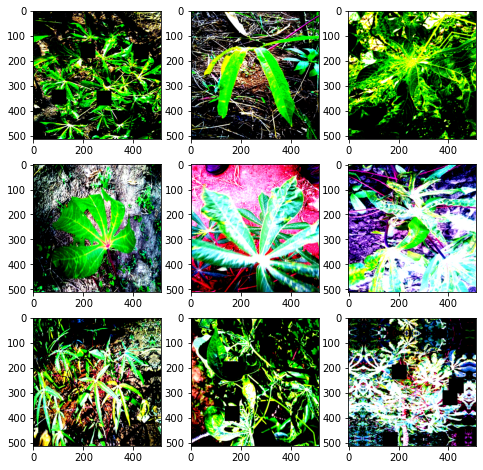

In [26]:
for image, label in train_loader:
    print(image.shape)
    print(label.shape)
    image = image.permute(0,2,3,1)
    #plt.imshow(image[0])
    break

w=5
h=5
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = image[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [27]:
del train_loader, train_dataset
gc.collect()

35

In [28]:
skf = StratifiedKFold(n_splits=CFG.n_fold, random_state=CFG.seed, shuffle=False)
train_csv['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(train_csv, train_csv['label'])):
    train_csv.loc[valid_idx, 'fold'] = i

In [30]:
train_csv.head()

,image_id,label,fold
0,591372512.jpg,2,0
1,2536863270.jpg,2,0
2,train-cmd-1331.jpg,3,0
3,2457355421.jpg,4,0
4,296442602.jpg,3,0


# Model

In [31]:
def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out

class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))
            
class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )
    
class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [32]:
class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1, 1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)
 
class Lambda(nn.Module):
    def __init__(self, f): super().__init__(); self.f = f

    def forward(self, x): return self.f(x)

class Mish(nn.Module):
    def __init__(self): super().__init__()

    def forward(self, x): return x*torch.tanh(F.softplus(x))

class Flatten(nn.Module):
    def __init__(self): super().__init__()

    def forward(self, x): return x.view(x.size(0), -1) 
    
sigmoid = nn.Sigmoid()
    
class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result
    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))

class Swish_Module(nn.Module):
    def forward(self, x):
        return Swish.apply(x)

In [ ]:
# class PretrainedCNN(nn.Module):
#     def __init__(self, model_name='se_resnext101_32x4d',
#                  in_channels=3, out_dim=5, use_bn=True,
#                  pretrained='imagenet'):
#         super(PretrainedCNN, self).__init__()
#         self.conv0 = nn.Conv2d(
#             in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
#         self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
#         activation = F.leaky_relu
#         #activation = F.relu
#         #activation = Swish_Module()
#         self.do_pooling = True
#         if self.do_pooling:
#             inch = self.base_model.last_linear.in_features
#         else:
#             inch = None
#         hdim = 512
#         lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
#         lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
#         self.lin_layers = nn.Sequential(lin1, lin2)

#     def forward(self, x):
#         h = self.conv0(x)
#         h = self.base_model.features(h)

#         if self.do_pooling:
#             h = torch.sum(h, dim=(-1, -2))
#         else:
#             bs, ch, height, width = h.shape
#             h = h.view(bs, ch*height*width)
#         for layer in self.lin_layers:
#             h = layer(h)
#         return h

In [35]:
class CustomEfficientNet(nn.Module):
    def __init__(self,in_channels=3, out_channels=5, use_bn=True, out_dim=5):
        super().__init__()
        m = ptcv_get_model("efficientnet_b3b", pretrained=True)
        self.enc = nn.Sequential(*list(m.children())[:-1])       
        activation = F.leaky_relu
        #activation = F.relu
        #activation = Swish_Module()
        self.do_pooling = True
        if self.do_pooling:
            inch = 1536
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = nn.Sequential(lin1, lin2)
        
    def forward(self, x):
        h = self.enc(x)
        
        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
        return h

In [37]:
# from torchsummary import summary
# model = CustomEfficientNet().to(device)
# print(model)
# #summary(model, (3, 256, 256))
# del model
# gc.collect()
# torch.cuda.empty_cache()

# Train

In [38]:
# From https://github.com/Bjarten/early-stopping-pytorch
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        #score = -val_loss
        score = val_loss

        if self.best_score is None:
            self.best_score = score
            #self.save_checkpoint(val_loss, model)
        elif score > self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            #self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss
        
class AverageScore(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        

def accuracy(y, y_a, y_b, lam):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = lam * pred_label.eq(y_a.data).sum().float() + (1 - lam) * pred_label.eq(y_b.data).sum().float()    
    acc = correct / count
    return acc

def accuracy_val(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    return acc 

In [39]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix(data, targets, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    return data, targets, shuffled_targets, lam

# loss 
def cutmix_criterion(criterion, preds, targets, shuffled_targets, lam):
    rate=0.7
    return lam * criterion(preds, targets) + (1 - lam) * criterion(preds, shuffled_targets)

# def mixup(data, targets, alpha):
#     indices = torch.randperm(data.size(0))
#     shuffled_data = data[indices]
#     shuffled_targets = targets[indices]

#     lam = np.random.beta(alpha, alpha)
#     data = data * lam + shuffled_data * (1 - lam)
#     return data, targets, shuffled_targets, lam

def mixup(x, y, alpha=0.6, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, preds, targets, shuffled_targets, lam):
    rate=0.7
    return lam * criterion(preds, targets) + (1 - lam) * criterion(preds, shuffled_targets)

#criterion = nn.CrossEntropyLoss(reduction='mean')

In [40]:
class NormalizedCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(NormalizedCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.log_softmax(pred, dim=1)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        nce = -1 * torch.sum(label_one_hot * pred, dim=1) / (- pred.sum(dim=1))
        return self.scale * nce.mean()
    
class ReverseCrossEntropy(torch.nn.Module):
    def __init__(self, num_classes, scale=1.0):
        super(ReverseCrossEntropy, self).__init__()
        self.device = device
        self.num_classes = num_classes
        self.scale = scale

    def forward(self, pred, labels):
        pred = F.softmax(pred, dim=1)
        pred = torch.clamp(pred, min=1e-7, max=1.0)
        label_one_hot = torch.nn.functional.one_hot(labels, self.num_classes).float().to(self.device)
        label_one_hot = torch.clamp(label_one_hot, min=1e-4, max=1.0)
        rce = (-1*torch.sum(pred * torch.log(label_one_hot), dim=1))
        return self.scale * rce.mean()
    
class NCEandRCE(torch.nn.Module):
    def __init__(self, alpha, beta, num_classes=5):
        super(NCEandRCE, self).__init__()
        self.num_classes = num_classes
        self.nce = NormalizedCrossEntropy(scale=alpha, num_classes=num_classes)
        self.rce = ReverseCrossEntropy(scale=beta, num_classes=num_classes)

    def forward(self, pred, labels):
        return self.nce(pred, labels) + self.rce(pred, labels)

In [44]:
def train(epoch):
    model.train()
    avg_train_loss = 0.0
    score = 0.0
    PREDS=[]
    TARGETS=[]
    bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (data, target) in bar:
        
        data, target = data.to(device).float(), target.to(device)#.float()
        optimizer.zero_grad()

        if fp16:
            with autocast():
                logits = model(data).float()
                loss = criterion(logits, target)
            score += accuracy_val(logits, target)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            logits = model(data).float()
            loss = criterion(logits, target)
            score += accuracy_val(logits, target)
            loss.backward()
            optimizer.step()
            
        #scheduler.step()
        
        avg_train_loss = (avg_train_loss * batch_idx + loss.detach().item()) / (batch_idx + 1)
        bar.set_description('average loss: %.5f' % (avg_train_loss))

    score = score/len(train_loader)
        
    neptune.send_metric('train_loss', avg_train_loss)
    neptune.send_metric('train_accuracy', score)
    neptune.send_metric('lr', optimizer.param_groups[0]['lr'])
    
    wandb.log({"train_loss": avg_train_loss, "train_accuracy": score, "lr":optimizer.param_groups[0]['lr']})
    
    torch.cuda.empty_cache()
    gc.collect()
    return avg_train_loss, score

In [45]:
def valid(epoch):
    model.eval()
    avg_val_loss = 0.0
    preds = []
    score = 0.0
    valid_labels = []
    tk1 = tqdm(enumerate(valid_loader), total=len(valid_loader))

    for i, (data, target) in tk1:

        data = data.to(device).float()
        target = target.to(device)#.float()

        with torch.no_grad():
            logits = model(data).float()
            score += accuracy_val(logits, target)

        loss = criterion(logits, target)
        avg_val_loss += loss.detach().item() #/ len(valid_loader)
    
    avg_val_loss = avg_val_loss / len(valid_loader)

    #scheduler.step(avg_val_loss)

    score = score/len(valid_loader)
    
    neptune.send_metric('valid_loss', avg_val_loss)
    neptune.send_metric('valid_accuracy', score)
    
    wandb.log({"valid_loss": avg_val_loss, "valid_accuracy": score})
    
    torch.cuda.empty_cache()
    gc.collect()

    return avg_val_loss, score#, preds, valid_labels

In [46]:
def run_main(epochs, fold):
    best_score = 0
    best_loss = np.inf
    best_preds = None
    for epoch in range(1, epochs+1):
        start_time = time.time()
        torch.cuda.empty_cache()
        gc.collect()
        scheduler.step(epoch-1)
        avg_train_loss, train_score = train(epoch) 
        avg_val_loss, valid_score = valid(epoch)
        #scheduler.step()
        
        elapsed = time.time() - start_time
        LOGGER.debug(f'  Epoch {epoch} - avg_train_loss: {avg_train_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.debug(f'  Epoch {epoch} - train_metric: {train_score}  valid_metric: {valid_score}')
        if valid_score>best_score:
            #print("score improved")
            torch.save(model.state_dict(), f'model_fold_{fold}.pt')
            #torch.save(model.state_dict(), 'model_{epoch:03}.pt'.format(epoch=epoch))
            best_score=valid_score

        checkpoint = {
            'epoch': epoch,
            'lr': optimizer.param_groups[0]['lr'],
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            }
        torch.save(checkpoint, 'checkpoint.pt')
        
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    return valid_score

In [48]:
oof_score = []
for fold in range(CFG.n_fold):
    print(f'Training fold {fold}')
    
    model = CustomEfficientNet().to(device)
    wandb.watch(model)
    criterion = NCEandRCE(alpha=1.0, beta=1.0)

    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, CFG.epochs)
    
    train_idx = np.where((train_csv['fold'] != fold))[0]
    valid_idx = np.where((train_csv['fold'] == fold))[0]

    train_data  = train_csv.loc[train_idx]#['image_id']
    valid_data = train_csv.loc[valid_idx]#['image_id']

    train_dataset = CassavaDataset(train_data, mode='train',transform=get_transforms(data='train'))
    valid_dataset = CassavaDataset(valid_data, mode='valid',transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=2, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size*3, shuffle=False,  num_workers=2, pin_memory=True)
    
    early_stopping = EarlyStopping(patience=10, verbose=False)
    #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CFG.lr, pct_start=0.45, cycle_momentum=True, 
    #                                steps_per_epoch=len(train_loader),epochs=CFG.epochs, div_factor=25.0, final_div_factor=1000.0)
    
    if fp16:
        scaler = GradScaler()
    
    score = run_main(CFG.epochs, fold)
    oof_score.append(score)
    del train_dataset, train_loader, valid_dataset, valid_loader, model
    torch.cuda.empty_cache()
    gc.collect()

Training fold 0


100%|██████████| 122/122 [03:00<00:00,  1.48s/it]
2021-01-16 03:44:51,728 DEBUG   Epoch 1 - avg_train_loss: 4.4683  avg_val_loss: 3.7338  time: 811s
2021-01-16 03:44:51,730 DEBUG   Epoch 1 - train_metric: 0.758608341217041  valid_metric: 0.8355937600135803
100%|██████████| 122/122 [02:33<00:00,  1.26s/it]
2021-01-16 03:57:46,622 DEBUG   Epoch 2 - avg_train_loss: 3.5911  avg_val_loss: 3.1276  time: 774s
2021-01-16 03:57:46,627 DEBUG   Epoch 2 - train_metric: 0.8209158778190613  valid_metric: 0.8425869345664978
100%|██████████| 122/122 [02:45<00:00,  1.35s/it]
2021-01-16 04:10:55,301 DEBUG   Epoch 3 - avg_train_loss: 3.0409  avg_val_loss: 2.7539  time: 788s
2021-01-16 04:10:55,303 DEBUG   Epoch 3 - train_metric: 0.8441574573516846  valid_metric: 0.857841968536377
100%|██████████| 122/122 [02:40<00:00,  1.32s/it]
2021-01-16 04:24:04,469 DEBUG   Epoch 4 - avg_train_loss: 2.6751  avg_val_loss: 2.4037  time: 789s
2021-01-16 04:24:04,473 DEBUG   Epoch 4 - train_metric: 0.8514733910560608  val

Training fold 1


100%|██████████| 122/122 [02:46<00:00,  1.36s/it]
2021-01-16 05:56:23,420 DEBUG   Epoch 1 - avg_train_loss: 4.4253  avg_val_loss: 3.5853  time: 792s
2021-01-16 05:56:23,423 DEBUG   Epoch 1 - train_metric: 0.7692819237709045  valid_metric: 0.8439370393753052
100%|██████████| 122/122 [02:44<00:00,  1.35s/it]
2021-01-16 06:09:37,881 DEBUG   Epoch 2 - avg_train_loss: 3.5691  avg_val_loss: 3.1838  time: 794s
2021-01-16 06:09:37,884 DEBUG   Epoch 2 - train_metric: 0.8239724636077881  valid_metric: 0.8629651069641113
100%|██████████| 122/122 [02:44<00:00,  1.35s/it]
2021-01-16 06:22:53,124 DEBUG   Epoch 3 - avg_train_loss: 3.0724  avg_val_loss: 2.6937  time: 795s
2021-01-16 06:22:53,132 DEBUG   Epoch 3 - train_metric: 0.8348534107208252  valid_metric: 0.8641523718833923
100%|██████████| 122/122 [02:51<00:00,  1.41s/it]
2021-01-16 06:36:15,716 DEBUG   Epoch 4 - avg_train_loss: 2.6309  avg_val_loss: 2.3729  time: 802s
2021-01-16 06:36:15,718 DEBUG   Epoch 4 - train_metric: 0.8597503304481506  v

EarlyStopping counter: 1 out of 10


100%|██████████| 122/122 [02:35<00:00,  1.28s/it]
2021-01-16 07:42:20,554 DEBUG   Epoch 9 - avg_train_loss: 1.7464  avg_val_loss: 1.8400  time: 785s
2021-01-16 07:42:20,558 DEBUG   Epoch 9 - train_metric: 0.8977071046829224  valid_metric: 0.8829529285430908
100%|██████████| 122/122 [02:36<00:00,  1.28s/it]
2021-01-16 07:55:27,314 DEBUG   Epoch 10 - avg_train_loss: 1.7115  avg_val_loss: 1.8248  time: 786s
2021-01-16 07:55:27,316 DEBUG   Epoch 10 - train_metric: 0.9029475450515747  valid_metric: 0.8851972818374634


Training fold 2


100%|██████████| 122/122 [02:38<00:00,  1.30s/it]
2021-01-16 08:08:30,321 DEBUG   Epoch 1 - avg_train_loss: 4.4820  avg_val_loss: 3.5911  time: 782s
2021-01-16 08:08:30,323 DEBUG   Epoch 1 - train_metric: 0.7571352124214172  valid_metric: 0.8413247466087341
100%|██████████| 122/122 [02:40<00:00,  1.32s/it]
2021-01-16 08:21:34,772 DEBUG   Epoch 2 - avg_train_loss: 3.5908  avg_val_loss: 3.0026  time: 784s
2021-01-16 08:21:34,777 DEBUG   Epoch 2 - train_metric: 0.8221458196640015  valid_metric: 0.8660311102867126
100%|██████████| 122/122 [02:40<00:00,  1.31s/it]
2021-01-16 08:34:37,769 DEBUG   Epoch 3 - avg_train_loss: 3.0650  avg_val_loss: 2.7237  time: 782s
2021-01-16 08:34:37,772 DEBUG   Epoch 3 - train_metric: 0.8401252031326294  valid_metric: 0.8512871265411377
100%|██████████| 122/122 [02:41<00:00,  1.33s/it]
2021-01-16 08:47:41,141 DEBUG   Epoch 4 - avg_train_loss: 2.7055  avg_val_loss: 2.2686  time: 783s
2021-01-16 08:47:41,143 DEBUG   Epoch 4 - train_metric: 0.8473174571990967  v

EarlyStopping counter: 1 out of 10


In [50]:
print("oof score: ",oof_score)
oof_csv = pd.DataFrame(data=oof_score, columns=['oof_score'])
oof_csv.to_csv('oof_scores.csv', index=False)

oof score:  [tensor(0.8937, device='cuda:0'), tensor(0.8852, device='cuda:0'), tensor(0.8960, device='cuda:0')]


In [ ]:
neptune.stop()
run.finish()